# Energy Meter Examples

## Energy estimations in Gem5

The Gem5EnergyMeter in Lisa uses the devlib Gem5PowerInstrument to extract energy information from the gem5 statistics file referenced in the energy meter field of the target configuration.

In [1]:
from conf import LisaLogging
LisaLogging.setup()

2017-08-16 18:12:20,847 INFO    : root         : Using LISA logging configuration:
2017-08-16 18:12:20,855 INFO    : root         :   /home/vagrant/dev/lisa/logging.conf


In [2]:
# One initial cell for imports
import json
import logging
import os

from env import TestEnv

# Suport for FTrace events parsing and visualization
import trappy
from trappy.ftrace import FTrace
from trace import Trace

# Support for plotting
# Generate plots inline
%matplotlib inline
import numpy
import pandas as pd
import matplotlib.pyplot as plt
from env import TestEnv

# RTApp configurator for generation of PERIODIC tasks
from wlgen import RTA, Ramp

## Target configuration
The target configuration is used to describe and configure your test environment. You can find more details in **examples/utils/testenv_example.ipynb**.

In [3]:
# Root path of the gem5 workspace
base = "/home/vagrant/gem5"

conf = {
    # Only 'linux' is supported by gem5 for now, 'android' is a WIP
    "platform"    : 'linux',
    
    # Preload settings for a specific target
    "board"       : 'gem5',
    
    # Devlib modules to load - "gem5stats" is required to use the power instrument
    "modules" : ["cpufreq", "bl", "gem5stats"],

    # Host that will run the gem5 instance
    "host"        : "workstation-lin",
    
    "gem5" : {
        # System to simulate
        "system" : {
            # Platform description
            "platform" : {
                # Gem5 platform description
                # LISA will also look for an optional gem5<platform> board file
                # located in the same directory as the description file.
                "description" : os.path.join(base, "juno.py"),
                "args" : [
                    "--power-model", # Platform-specific parameter enabling power modelling
                    "--juno-revision 2",
                    # Resume simulation from a previous checkpoint
                    # Checkpoint must be taken before Virtio folders are mounted
                    #"--checkpoint-indir /data/tmp/Results_LISA/gem5",
                    #"--checkpoint-resume 1",
                ]
            },
            # Kernel compiled for gem5 with Virtio flags
            "kernel"   : os.path.join(base, "product/", "vmlinux"),
            # DTB of the system to simulate
            "dtb"      : os.path.join(base, "product/", "armv8_juno_r2.dtb"),
            # Disk of the distrib to run
            "disk"     : os.path.join(base, "aarch64-ubuntu-trusty-headless.img")
        },
        # gem5 settings
        "simulator" : {
            # Path to gem5 binary
            "bin"     : os.path.join(base, "gem5/build/ARM/gem5.fast"),
            # Args to be given to the binary
            "args" : [
                # Zilch
            ],
        }
    },
    
    # Tools required by the experiments
    "tools"   : ['trace-cmd', 'sysbench', 'rt-app'],
    
    # Output directory on host
    "results_dir" : "gem5_res",
    
    # Energy Meters configuration based on Gem5 stats
    "emeter" : {
        "instrument" : "gem5",
        "conf" : {
            # Zilch
        },
        # Each channel here must refer to a specific **power** field in the stats file. 
        'channel_map' : {
            'Core0S' : 'system.cluster0.cores0.power_model.static_power',
            'Core0D' : 'system.cluster0.cores0.power_model.dynamic_power',
            'Core1S' : 'system.cluster0.cores1.power_model.static_power',
            'Core1D' : 'system.cluster0.cores1.power_model.dynamic_power',
            'Core2S' : 'system.cluster0.cores2.power_model.static_power',
            'Core2D' : 'system.cluster0.cores2.power_model.dynamic_power',
            'Core3S' : 'system.cluster0.cores3.power_model.static_power',
            'Core3D' : 'system.cluster0.cores3.power_model.dynamic_power',
            'Core4S' : 'system.cluster1.cores0.power_model.static_power',
            'Core4D' : 'system.cluster1.cores0.power_model.dynamic_power',
            'Core5S' : 'system.cluster1.cores1.power_model.static_power',
            'Core5D' : 'system.cluster1.cores1.power_model.dynamic_power',
        },
    },
}

In [5]:
# This can take a lot of time ...
te = TestEnv(conf, wipe=True)
target = te.target

2017-08-16 18:12:21,692 INFO    : TestEnv      : Using base path: /data/work/dev/lisa
2017-08-16 18:12:21,693 INFO    : TestEnv      : Loading custom (inline) target configuration
2017-08-16 18:12:21,694 WARNING : TestEnv      : Wipe previous contents of the results folder:
2017-08-16 18:12:21,694 WARNING : TestEnv      :    /data/work/dev/lisa/results/gem5_res
2017-08-16 18:12:22,796 INFO    : TestEnv      : Loading board:
2017-08-16 18:12:22,796 INFO    : TestEnv      :    /data/work/dev/lisa/libs/utils/platforms/gem5juno.json
2017-08-16 18:12:22,798 INFO    : gem5         : Creating temporary directory for interaction  with gem5 via virtIO: /tmp/wa_0
2017-08-16 18:12:22,798 INFO    : gem5         : Starting the gem5 simulator
2017-08-16 18:12:25,815 INFO    : TestEnv      : Devlib modules to load: ['bl', 'cpufreq', 'gem5stats']
2017-08-16 18:12:25,816 INFO    : TestEnv      : Connecting linux target:
2017-08-16 18:12:25,817 INFO    : TestEnv      :   username : root
2017-08-16 18:12

2017-08-16 19:44:53,967 INFO    : gem5-connection : Trying to log in to gem5 device
2017-08-16 19:46:04,029 INFO    : gem5-connection : Trying to log in to gem5 device
2017-08-16 19:47:14,118 INFO    : gem5-connection : Trying to log in to gem5 device
2017-08-16 19:48:24,228 INFO    : gem5-connection : Trying to log in to gem5 device
2017-08-16 19:49:34,323 INFO    : gem5-connection : Trying to log in to gem5 device
2017-08-16 19:50:44,419 INFO    : gem5-connection : Trying to log in to gem5 device
2017-08-16 19:51:54,523 INFO    : gem5-connection : Trying to log in to gem5 device
2017-08-16 19:53:04,635 INFO    : gem5-connection : Trying to log in to gem5 device
2017-08-16 19:54:14,739 INFO    : gem5-connection : Trying to log in to gem5 device
2017-08-16 19:55:24,835 INFO    : gem5-connection : Trying to log in to gem5 device
2017-08-16 19:56:34,901 INFO    : gem5-connection : Trying to log in to gem5 device
2017-08-16 20:01:16,122 INFO    : gem5-connection : Successfully logged in
2

2017-08-17 01:14:31,053 WARNING : ssh          : Destination file rt-app-task1-0.log already exists!
2017-08-17 01:15:43,793 WARNING : ssh          : Destination file rta_calib_00.json already exists!
2017-08-17 01:15:43,793 INFO    : RTApp        : CPU5 calibration...
2017-08-17 01:15:48,155 INFO    : Workload     : Setup new workload rta_calib
2017-08-17 01:16:01,836 INFO    : Workload     : Workload duration defined by longest task
2017-08-17 01:16:01,837 INFO    : Workload     : Default policy: SCHED_OTHER
2017-08-17 01:16:01,838 INFO    : Workload     : ------------------------
2017-08-17 01:16:01,838 INFO    : Workload     : task [task1], sched: {'policy': 'FIFO', 'prio': 0}
2017-08-17 01:16:01,839 INFO    : Workload     :  | loops count: 1
2017-08-17 01:16:01,839 INFO    : Workload     : + phase_000001: duration 1.000000 [s] (10 loops)
2017-08-17 01:16:01,840 INFO    : Workload     : |  period   100000 [us], duty_cycle  50 %
2017-08-17 01:16:01,840 INFO    : Workload     : |  ru

## Workload execution
For this example, we will investigate the energy consumption of the target while running a random workload. Our observations will be made using the RT-App decreasing ramp workload defined below. With such a workload, the system load goes from high to low over time. We expect to see a similar pattern in power consumption.

In [6]:
# Create and RTApp RAMP tasks
rtapp = RTA(target, 'ramp', calibration=te.calibration())
rtapp.conf(kind='profile',
           params={
                'ramp1' : Ramp(
                    start_pct =  95,
                    end_pct   =  5,
                    delta_pct =   10,
                    time_s    =   0.1).get(),
                'ramp2' : Ramp(
                    start_pct =  90,
                    end_pct   =  30,
                    delta_pct =   20,
                    time_s    =   0.2).get(),
          })

2017-08-17 02:38:05,960 INFO    : Workload     : Setup new workload ramp
2017-08-17 02:38:19,705 INFO    : Workload     : Workload duration defined by longest task
2017-08-17 02:38:19,706 INFO    : Workload     : Default policy: SCHED_OTHER
2017-08-17 02:38:19,707 INFO    : Workload     : ------------------------
2017-08-17 02:38:19,708 INFO    : Workload     : task [ramp1], sched: using default policy
2017-08-17 02:38:19,708 INFO    : Workload     :  | loops count: 1
2017-08-17 02:38:19,709 INFO    : Workload     : + phase_000001: duration 0.100000 [s] (1 loops)
2017-08-17 02:38:19,709 INFO    : Workload     : |  period   100000 [us], duty_cycle  95 %
2017-08-17 02:38:19,710 INFO    : Workload     : |  run_time  95000 [us], sleep_time   5000 [us]
2017-08-17 02:38:19,710 INFO    : Workload     : + phase_000002: duration 0.100000 [s] (1 loops)
2017-08-17 02:38:19,710 INFO    : Workload     : |  period   100000 [us], duty_cycle  85 %
2017-08-17 02:38:19,711 INFO    : Workload     : |  ru

'ramp_00'

## Energy estimation 
The gem5 energy meters feature two methods: **reset** and **report**.
* The **reset** method will start sampling the channels defined in the target configuration.
* The **report** method will stop the sampling and produce a CSV file containing power samples together with a JSON file summarizing the total energy consumption of each channel.

In [7]:
# Start emeters & run workload
te.emeter.reset()
rtapp.run(out_dir=te.res_dir)
nrg_rep = te.emeter.report(te.res_dir)

2017-08-17 02:40:06,494 INFO    : Workload     : Workload execution START:
2017-08-17 02:40:06,494 INFO    : Workload     :    /home/root/devlib-target/bin/rt-app /home/root/devlib-target/ramp_00.json 2>&1


## Data analysis

In [8]:
logging.info("Measured channels energy:")
print json.dumps(nrg_rep.channels, indent=4)

2017-08-17 04:43:29,481 INFO    : root         : Measured channels energy:


{
    "system.cluster0.cores2.power_model.dynamic_power": 0.0015930811939999978, 
    "system.cluster0.cores2.power_model.static_power": 5.5844099999999809e-07, 
    "system.cluster0.cores0.power_model.static_power": 1.3219494999999962e-05, 
    "system.cluster0.cores3.power_model.dynamic_power": 0.15863506186750015, 
    "system.cluster0.cores0.power_model.dynamic_power": 0.0027130621879999954, 
    "system.cluster1.cores1.power_model.dynamic_power": 0.013573508823999998, 
    "system.cluster0.cores3.power_model.static_power": 0.0009470161700000008, 
    "system.cluster0.cores1.power_model.static_power": 1.930225999999995e-06, 
    "system.cluster1.cores1.power_model.static_power": 0.00015487269799999999, 
    "system.cluster1.cores0.power_model.dynamic_power": 0.29683561018450011, 
    "system.cluster0.cores1.power_model.dynamic_power": 0.0017484881624999973, 
    "system.cluster1.cores0.power_model.static_power": 0.0029071225505000018
}


In [9]:
logging.info("DataFrame of collected samples (only first 5)")
nrg_rep.data_frame.head()

2017-08-17 04:43:29,513 INFO    : root         : DataFrame of collected samples (only first 5)


,sim_seconds,system.cluster0.cores0.power_model.dynamic_power,system.cluster0.cores0.power_model.static_power,system.cluster0.cores1.power_model.dynamic_power,system.cluster0.cores1.power_model.static_power,system.cluster0.cores2.power_model.dynamic_power,system.cluster0.cores2.power_model.static_power,system.cluster0.cores3.power_model.dynamic_power,system.cluster0.cores3.power_model.static_power,system.cluster1.cores0.power_model.dynamic_power,system.cluster1.cores0.power_model.static_power,system.cluster1.cores1.power_model.dynamic_power,system.cluster1.cores1.power_model.static_power
,time,power,power,power,power,power,power,power,power,power,power,power,power
0.000000,0.000723,0.022943,0.000065,0.017251,0.000001,0.017685,0.000007,0.057793,0.000488,0.022847,0.000234,0.002798,0.000007
0.010000,0.010000,0.024210,0.000085,0.016583,0.000000,0.016586,0.000000,0.063653,0.000479,0.005193,0.000034,0.081359,0.000826
0.017737,0.007737,0.000556,0.000003,0.000479,0.000002,0.000351,0.000000,0.082148,0.000488,0.455068,0.004354,0.113078,0.001088
0.019614,0.001877,0.000255,0.000000,0.000000,0.000000,0.000000,0.000000,0.081870,0.000488,0.189404,0.003608,0.010095,0.000206
0.020000,0.000386,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.082142,0.000488,0.561227,0.005374,0.000000,0.000000


In [10]:
# Obtain system level energy by ...
df = nrg_rep.data_frame
# ... summing the dynamic power of all cores to obtain total dynamic power, ...
df["total_dynamic"] = df[('system.cluster0.cores0.power_model.dynamic_power', 'power')] + \
                      df[('system.cluster0.cores1.power_model.dynamic_power', 'power')] + \
                      df[('system.cluster0.cores2.power_model.dynamic_power', 'power')] + \
                      df[('system.cluster0.cores3.power_model.dynamic_power', 'power')] + \
                      df[('system.cluster1.cores0.power_model.dynamic_power', 'power')] + \
                      df[('system.cluster1.cores1.power_model.dynamic_power', 'power')]
# ... summing the static power of all cores to obtain total static power and ...
df["total_static"] = df[('system.cluster0.cores0.power_model.static_power', 'power')] + \
                      df[('system.cluster0.cores1.power_model.static_power', 'power')] + \
                      df[('system.cluster0.cores2.power_model.static_power', 'power')] + \
                      df[('system.cluster0.cores3.power_model.static_power', 'power')] + \
                      df[('system.cluster1.cores0.power_model.static_power', 'power')] + \
                      df[('system.cluster1.cores1.power_model.static_power', 'power')]
# ... summing the dynamic and static powers
df["total"] = df["total_dynamic"] + df["total_static"]

2017-08-17 04:43:29,627 INFO    : root         : Plot of collected power samples


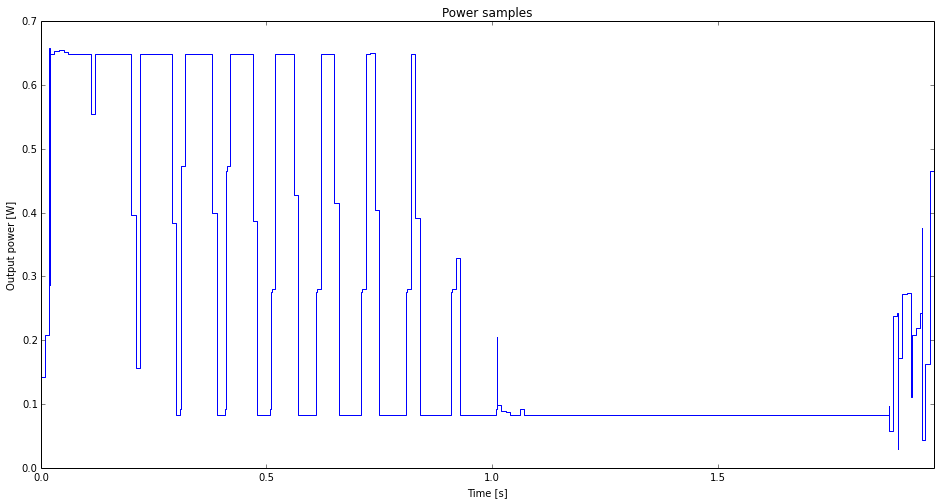

In [11]:
logging.info("Plot of collected power samples")
axes =df[('total')].plot(figsize=(16,8),
                         drawstyle='steps-post');
axes.set_title('Power samples');
axes.set_xlabel('Time [s]');
axes.set_ylabel('Output power [W]');

We can see on the above plot that the system level power consumption decreases over time (in average). **This is coherent with the expected behaviour given the decreasing ramp workload under consideration.**

2017-08-17 04:43:29,810 INFO    : root         : Power distribution


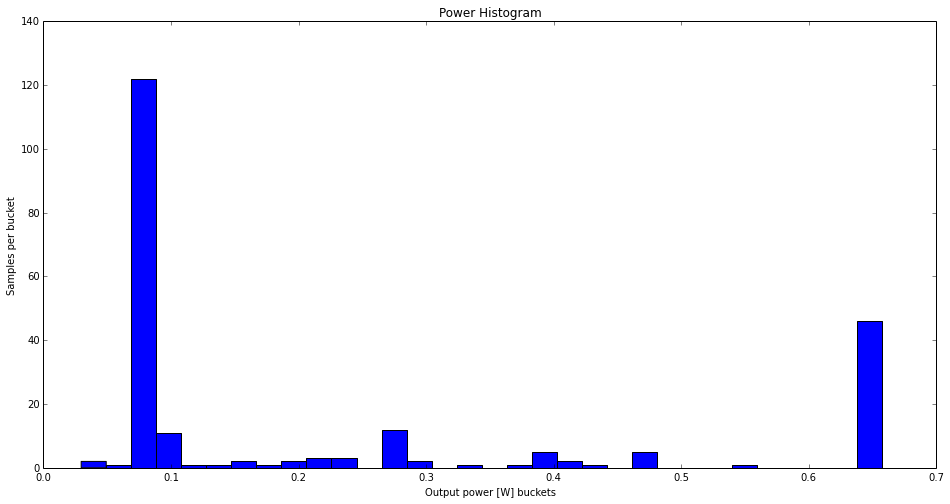

In [12]:
logging.info("Power distribution")
axes = df[('total')].plot(kind='hist', bins=32,
                          figsize=(16,8));
axes.set_title('Power Histogram');
axes.set_xlabel('Output power [W] buckets');
axes.set_ylabel('Samples per bucket');

In [13]:
logging.info("Plot of collected power samples")
nrg_rep.data_frame.describe(percentiles=[0.90, 0.95, 0.99]).T

2017-08-17 04:43:30,013 INFO    : root         : Plot of collected power samples


,,count,mean,std,min,50%,90%,95%,99%,max
sim_seconds,time,225.0,8.800516e-03,0.002832,0.000246,0.010000,0.010000,0.010000,0.010000,0.010000
system.cluster0.cores0.power_model.dynamic_power,power,225.0,1.860018e-03,0.006584,0.000000,0.000000,0.000170,0.021604,0.028975,0.036593
system.cluster0.cores0.power_model.static_power,power,225.0,9.782222e-06,0.000036,0.000000,0.000000,0.000000,0.000099,0.000165,0.000255
system.cluster0.cores1.power_model.dynamic_power,power,225.0,1.103284e-03,0.004315,0.000000,0.000000,0.000000,0.013626,0.021795,0.023048
system.cluster0.cores1.power_model.static_power,power,225.0,1.160000e-06,0.000008,0.000000,0.000000,0.000000,0.000002,0.000046,0.000076
system.cluster0.cores2.power_model.dynamic_power,power,225.0,1.011360e-03,0.004075,0.000000,0.000000,0.000000,0.013540,0.018692,0.025682
system.cluster0.cores2.power_model.static_power,power,225.0,4.000000e-07,0.000003,0.000000,0.000000,0.000000,0.000000,0.000009,0.000042
system.cluster0.cores3.power_model.dynamic_power,power,225.0,7.881513e-02,0.013059,0.003832,0.082498,0.082545,0.082548,0.082639,0.082641
system.cluster0.cores3.power_model.static_power,power,225.0,4.727467e-04,0.000067,0.000003,0.000488,0.000488,0.000488,0.000488,0.000488
system.cluster1.cores0.power_model.dynamic_power,power,225.0,1.475154e-01,0.227330,0.000000,0.000000,0.561185,0.561188,0.561307,0.561547


In [14]:
# Don't forget to stop Gem5
target.disconnect()

2017-08-17 04:43:30,123 INFO    : gem5-connection : Gracefully terminating the gem5 simulation.
2017-08-17 04:43:37,381 INFO    : gem5-connection : Removing the temporary directory
